# Online A/B testing

## Sequential probability ratio test (sequential sampling)

**Hypotheses**

- $H_0: p = p_0$ (null hypothesis — no effect / no difference / $p$ is the same for all)
- $H_a: p = p_1$ (alternative hypothesis — some effect / some difference / one $p$ is different to the others)

**Likelihood**

To denote the likelihood of a parameter $\theta$ given some data $\mathcal{D}$, we use the probability of the data given the parameter, which can be written as:

$$
\mathcal{L}(\theta | \mathcal{D}) = P(\mathcal{D} | \theta)
$$

These two expressions are mathematically equivalent because they represent the same quantity—the probability of observing the data $\mathcal{D}$ given the parameter $\theta$—but are written differently to emphasize their distinct roles: $\mathcal{L}(\theta \mid \mathcal{D})$ is used for parameter inference (likelihood), while $P(\mathcal{D} \mid \theta)$ is used for describing the data-generating process (probability).


Likelihood function for Bernoulli distribution

$$\mathcal{L}(p) = \prod_{i=1}^n p^{x_i} (1-p)^{1-x_i}$$

**Likelihood ratio**

To denote the likelihood ratio comparing two parameter values $\theta_1$ and $\theta_2$ given data $\mathcal{D}$:

$$\Lambda = \frac{\mathcal{L}(\theta_1 | D)}{\mathcal{L}(\theta_2 | D)}$$

For Bernoulli trials, the likelihood ratio $\Lambda_n$ after $n$ observations is given by:

$$\Lambda_n = \frac{L(p_1)}{L(p_0)} = \frac{\prod_{i=1}^n p_1^{S_i} (1-p_1)^{1-S_i}}{\prod_{i=1}^n p_0^{S_i} (1-p_0)^{1-S_i}}$$


This simplifies to:

$$\Lambda_n = \left(\frac{p_1}{p_0}\right)^{S_n} \left(\frac{1 - p_1}{1 - p_0}\right)^{n - S_n} $$
where $S_n$ is the number of successes in n trials.

**Log likelihood ratio (batch)**

Log likelihood ratio for Bernoulli trials, given $S_n$ (number of successes) and $n$ (total number of observations):

$$
\log \Lambda_n = \underbrace{S_n \log\left(\frac{p_1}{p_0}\right)}_{\text{success term}} + \underbrace{(n - S_n) \log\left(\frac{1 - p_1}{1 - p_0}\right)}_{\text{failure term}}
$$


**Bonferroni adjustment for multiple comparisons**
- If you have $k$ variants, you need to perform  $\binom{k}{2}$ pairwise comparisons.
- Adjust the significance level for each test using the Bonferroni correction: 

$$\alpha{\prime} = \frac{\alpha}{\binom{k}{2}}$$


**Decision boundaries**

The sequential probability ratio test (SPRT) uses decision boundaries $A$ and $B$:
 $$A = \frac{1 - \beta}{\alpha} $$
 $$ B = \frac{\beta}{1 - \alpha} $$

 where $\alpha$ is the significance level, $\beta$ is the false negative rate and $(1 - \beta)$ is the power.

 **Logarithmic decision boundaries**

 Taking the logarithm of the decision boundaries:
 $$ \log(A) = \log\left(\frac{1 - \beta}{\alpha}\right) $$
$$ \log(B) = \log\left(\frac{\beta}{1 - \alpha}\right)  $$




 **Decision rules**
 - $\Lambda_n < B \Rightarrow H_0$
 - $\Lambda_n > A \Rightarrow H_a$

 or equivalently

 - $\log \Lambda_n < \log(B) \Rightarrow H_0$
 - $\log \Lambda_n > \log(A) \Rightarrow H_a$




In [47]:
import numpy as np

def sprt_binary_pairwise(s, n, alpha, beta):
    # Number of comparisons (k choose 2)
    k = len(s)
    num_comparisons = (k * (k - 1)) // 2
    alpha_prime = alpha / num_comparisons

    # Step 1: Compute decision boundaries without Bonferroni correction
    A = (1 - beta) / alpha
    B = beta / (1 - alpha)
    log_A = np.log(A)
    log_B = np.log(B)

    # Step 2: Compute decision boundaries with Bonferroni correction
    A_prime = (1 - beta) / alpha_prime
    B_prime = beta / (1 - alpha_prime)
    log_A_prime = np.log(A_prime)
    log_B_prime = np.log(B_prime)

    # Initialize results storage
    log_results = []
    results = []
    log_results_prime = []
    results_prime = []

    # Step 3: Compute pairwise likelihood ratios
    for i in range(len(s)):
        for j in range(i + 1, len(s)):
            p_i = s[i] / n[i]
            p_j = s[j] / n[j]

            # Compute log-likelihood ratio for arm i vs arm j
            log_lr_ij = s[i] * np.log(p_i / p_j) + (n[i] - s[i]) * np.log((1 - p_i) / (1 - p_j))
            log_lr_ji = s[j] * np.log(p_j / p_i) + (n[j] - s[j]) * np.log((1 - p_j) / (1 - p_i))
            
            # Combine the log-likelihood ratios
            log_lr = log_lr_ij + log_lr_ji

            # Compute likelihood ratio for arm i vs arm j
            lr = np.exp(log_lr)

            # Decision rule for this pair using log-likelihood ratios without Bonferroni correction
            if log_lr <= log_A:
                log_results.append((i, j, "No significant difference (log)"))
            elif log_lr >= log_B:
                if p_i > p_j:
                    log_results.append((i, j, f"Arm {i+1} is significantly better than Arm {j+1} (log)"))
                else:
                    log_results.append((i, j, f"Arm {j+1} is significantly better than Arm {i+1} (log)"))
            else:
                log_results.append((i, j, "Continue sampling (log)"))

            # Decision rule for this pair using likelihood ratios without Bonferroni correction
            if lr <= A:
                results.append((i, j, "No significant difference"))
            elif lr >= B:
                if p_i > p_j:
                    results.append((i, j, f"Arm {i+1} is significantly better than Arm {j+1}"))
                else:
                    results.append((i, j, f"Arm {j+1} is significantly better than Arm {i+1}"))
            else:
                results.append((i, j, "Continue sampling"))

            # Decision rule for this pair using log-likelihood ratios with Bonferroni correction
            if log_lr <= log_A_prime:
                log_results_prime.append((i, j, "No significant difference (log)"))
            elif log_lr >= log_B_prime:
                if p_i > p_j:
                    log_results_prime.append((i, j, f"Arm {i+1} is significantly better than Arm {j+1} (log)"))
                else:
                    log_results_prime.append((i, j, f"Arm {j+1} is significantly better than Arm {i+1} (log)"))
            else:
                log_results_prime.append((i, j, "Continue sampling (log)"))

            # Decision rule for this pair using likelihood ratios with Bonferroni correction
            if lr <= A_prime:
                results_prime.append((i, j, "No significant difference"))
            elif lr >= B_prime:
                if p_i > p_j:
                    results_prime.append((i, j, f"Arm {i+1} is significantly better than Arm {j+1}"))
                else:
                    results_prime.append((i, j, f"Arm {j+1} is significantly better than Arm {i+1}"))
            else:
                results_prime.append((i, j, "Continue sampling"))

    # Step 5: Compile overall decision
    overall_decision = (
        f"Original alpha: {alpha:.4f}, Adjusted alpha (alpha'): {alpha_prime:.4f}\n\n"
        f"Decision Boundaries:\n"
        f"A: {A:.4f}, B: {B:.4f}\n"
        f"log(A): {log_A:.4f}, log(B): {log_B:.4f}\n\n"
        f"Decision Boundaries with Bonferroni Correction:\n"
        f"A': {A_prime:.4f}, B': {B_prime:.4f}\n"
        f"log(A'): {log_A_prime:.4f}, log(B'): {log_B_prime:.4f}\n\n"
    )
    
    overall_decision += "Results of pairwise comparisons using log-likelihood ratios (without Bonferroni correction):\n"
    for result in log_results:
        overall_decision += f"Comparison between Arm {result[0]+1} and Arm {result[1]+1}: {result[2]}\n"

    overall_decision += "\nResults of pairwise comparisons using likelihood ratios (without Bonferroni correction):\n"
    for result in results:
        overall_decision += f"Comparison between Arm {result[0]+1} and Arm {result[1]+1}: {result[2]}\n"
    
    overall_decision += "\nResults of pairwise comparisons using log-likelihood ratios (with Bonferroni correction):\n"
    for result in log_results_prime:
        overall_decision += f"Comparison between Arm {result[0]+1} and Arm {result[1]+1}: {result[2]}\n"

    overall_decision += "\nResults of pairwise comparisons using likelihood ratios (with Bonferroni correction):\n"
    for result in results_prime:
        overall_decision += f"Comparison between Arm {result[0]+1} and Arm {result[1]+1}: {result[2]}\n"
    
    # Print conversion rates for each arm
    conversion_rates = [s[i] / n[i] for i in range(len(s))]
    overall_decision += "\nConversion rates for each arm:\n"
    for i, rate in enumerate(conversion_rates):
        overall_decision += f"Arm {i+1}: {rate:.4f}\n"
    
    return overall_decision

# Example usage
s = [5, 7, 40]  # number of successes in each arm
n = [474, 478, 438]  # number of trials in each arm
alpha = 0.05 # Type I error rate
beta = 0.2  # Type II error rate

decision = sprt_binary_pairwise(s, n, alpha, beta)
print("Decision:")
print(decision)

Decision:
Original alpha: 0.0500, Adjusted alpha (alpha'): 0.0167

Decision Boundaries:
A: 16.0000, B: 0.2105
log(A): 2.7726, log(B): -1.5581

Decision Boundaries with Bonferroni Correction:
A': 48.0000, B': 0.2034
log(A'): 3.8712, log(B'): -1.5926

Results of pairwise comparisons using log-likelihood ratios (without Bonferroni correction):
Comparison between Arm 1 and Arm 2: No significant difference (log)
Comparison between Arm 1 and Arm 3: Arm 3 is significantly better than Arm 1 (log)
Comparison between Arm 2 and Arm 3: Arm 3 is significantly better than Arm 2 (log)

Results of pairwise comparisons using likelihood ratios (without Bonferroni correction):
Comparison between Arm 1 and Arm 2: No significant difference
Comparison between Arm 1 and Arm 3: Arm 3 is significantly better than Arm 1
Comparison between Arm 2 and Arm 3: Arm 3 is significantly better than Arm 2

Results of pairwise comparisons using log-likelihood ratios (with Bonferroni correction):
Comparison between Arm 1 a

## Multi-Armed Bandit

- Let  $K$  be the number of arms.
- Let  $T$  be the number of time steps.
- Let  $\theta_k$  be the unknown parameter (e.g., success probability) of arm $k$
- Let  $\mathcal{D}_t$  represent the data observed up to time $t$.


**Prior**

Assume the prior distribution for  $\theta_k$  is 
$$P(\theta_k)$$

**Likelihood**

The likelihood of observing data $\mathcal{D}_t$  given  $\theta_k$  is  

$$P(\mathcal{D}_t \mid \theta_k)$$


**Posterior**
$$
P(\theta_k \mid \mathcal{D}_t) = \frac{P(\mathcal{D}_t \mid \theta_k) P(\theta_k)}{P(\mathcal{D}_t)}
$$


### Thompson sampling

Thompson Sampling is a popular algorithm for solving the Bayesian multi-armed bandit problem. It involves sampling from the posterior distribution of each arm and choosing the arm with the highest sample.

- Sample $\hat{\theta}_k$  from the posterior distribution $P(\theta_k \mid \mathcal{D}_t)$  for each arm  $k$
- Select the arm  $k^*$  with the highest sampled value:
$$
k^* = \arg\max_k \hat{\theta}_k
$$

- Observe the reward  $r_t$  for the chosen arm  $k^*$ 
- Update the posterior distribution  $P(\theta_{k^*} \mid \mathcal{D}_{t+1})$  based on the observed reward.

**Updating the posterior**

If the reward distribution is Bernoulli, the prior can be modeled as a Beta distribution, which is conjugate to the Bernoulli distribution.

$$
\text{Beta}(\alpha, \beta) = \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha) \Gamma(\beta)} x^{\alpha - 1} (1 - x)^{\beta - 1}
$$

If arm  $k$ is played and reward $r$  is observed:
- $\alpha_k \leftarrow \alpha_k + r$
- $\beta_k \leftarrow \beta_k + 1 - r$

True conversion rates: [0.02, 0.03, 0.04, 0.05]
Estimated conversion rates: [0.01365188 0.03128761 0.04135618 0.04360465]
Number of trials per variant: [ 293.  831. 2684. 6192.]
Number of successes per variant: [  4.  26. 111. 270.]


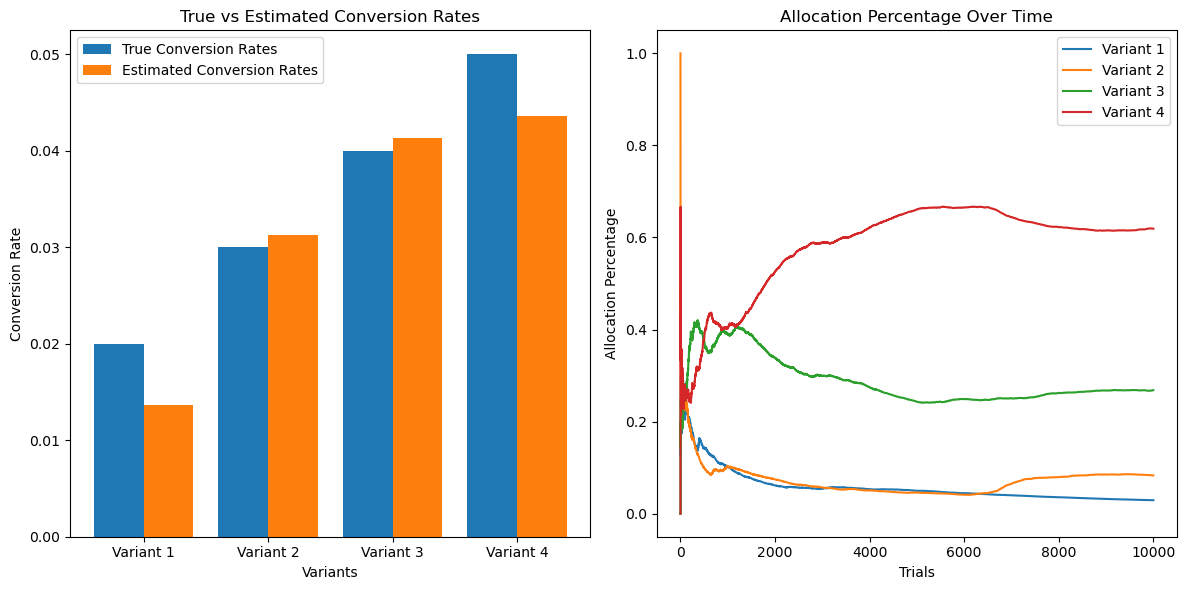

In [41]:
import numpy as np
import matplotlib.pyplot as plt

def choose_variant(successes, trials):
    samples = [np.random.beta(successes[i] + 1, trials[i] - successes[i] + 1) for i in range(len(successes))]
    return np.argmax(samples)

def update(successes, trials, chosen_variant, reward):
    trials[chosen_variant] += 1
    successes[chosen_variant] += reward

# Example usage
# np.random.seed(42)  # For reproducibility

# Simulate true conversion rates for K variants
true_conversion_rates = [0.02, 0.03, 0.04, 0.05]  # True conversion rates for 4 variants
K = len(true_conversion_rates)

# Initialize successes and trials
successes = np.zeros(K)
trials = np.zeros(K)

# Simulate the process for a number of trials
n_trials = 10000
rewards = np.zeros(n_trials)
allocation = np.zeros((n_trials, K))

for t in range(n_trials):
    chosen_variant = choose_variant(successes, trials)
    reward = np.random.rand() < true_conversion_rates[chosen_variant]
    update(successes, trials, chosen_variant, reward)
    rewards[t] = reward
    allocation[t] = trials / np.sum(trials)

# Calculate estimated conversion rates
estimated_conversion_rates = successes / trials

# Print results
print(f"True conversion rates: {true_conversion_rates}")
print(f"Estimated conversion rates: {estimated_conversion_rates}")
print(f"Number of trials per variant: {trials}")
print(f"Number of successes per variant: {successes}")

# Plot the results
plt.figure(figsize=(12, 6))

# Plot true vs estimated conversion rates
plt.subplot(1, 2, 1)
x = np.arange(K)
plt.bar(x - 0.2, true_conversion_rates, 0.4, label='True Conversion Rates')
plt.bar(x + 0.2, estimated_conversion_rates, 0.4, label='Estimated Conversion Rates')
plt.xticks(x, [f'Variant {i+1}' for i in range(K)])
plt.xlabel('Variants')
plt.ylabel('Conversion Rate')
plt.legend()
plt.title('True vs Estimated Conversion Rates')

# Plot allocation percentages over time
plt.subplot(1, 2, 2)
for i in range(K):
    plt.plot(allocation[:, i], label=f'Variant {i+1}')
plt.xlabel('Trials')
plt.ylabel('Allocation Percentage')
plt.legend()
plt.title('Allocation Percentage Over Time')

plt.tight_layout()
plt.show()

# MDE

In [63]:
import scipy.stats as stats
import numpy as np

def sample_size_for_mde(p0, mde_percentage, alpha, power):
    # Convert the MDE from a percentage to an absolute difference
    mde = p0 * mde_percentage / 100
    
    # Calculate the critical values for alpha and power
    z_alpha = stats.norm.ppf(1 - alpha / 2)
    z_beta = stats.norm.ppf(power)
    
    # Calculate the proportion for the alternative hypothesis
    p1 = p0 + mde
    
    # Calculate the pooled standard deviation
    pooled_std = np.sqrt((p0 * (1 - p0) + p1 * (1 - p1)) / 2)
    
    # Calculate the sample size
    n = ((z_alpha * np.sqrt(2 * pooled_std) + z_beta * np.sqrt(p0 * (1 - p0) + p1 * (1 - p1))) ** 2) / mde ** 2
    
    return np.ceil(n)  # Return the ceiling of the calculated sample size

# Example usage:
p0 = 0.11  # Baseline proportion
mde_percentage = 30  # Minimum Detectable Effect as a percentage (50% increase)
alpha = 0.1  # Significance level
power = 0.80  # Power (80%)

required_sample_size = sample_size_for_mde(p0, mde_percentage, alpha, power)
print(f"Required sample size per group: {required_sample_size}")

Required sample size per group: 2766.0
